In [1]:
import pandas as pd
import numpy as np 
import nltk
import matplotlib.pyplot as plt

import os
from gensim.models.wrappers import LdaMallet
os.environ['MALLET_HOME'] = 'C:\\Users\\35196\\mallet-2.0.8'
MALLET_PATH = 'C:\\Users\\35196\\mallet-2.0.8\\bin\\mallet'

# text analysis
import gensim
from gensim.models import LdaModel, ldamodel
from gensim.models import LsiModel, lsimodel
from gensim.models import Phrases
from gensim.models import CoherenceModel  
from gensim.corpora import Dictionary
from gensim.similarities import MatrixSimilarity

# import data

In [2]:
data = pd.read_csv('DataAnalyst.csv', index_col=0)
data.head(10)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True
5,Data Analyst,$37K-$66K (Glassdoor est.),About Cubist\nCubist Systematic Strategies is ...,3.9,Point72\n3.9,"New York, NY","Stamford, CT",1001 to 5000 employees,2014,Company - Private,Investment Banking & Asset Management,Finance,Unknown / Non-Applicable,-1,-1
6,Business/Data Analyst (FP&A),$37K-$66K (Glassdoor est.),Two Sigma is a different kind of investment ma...,4.4,Two Sigma\n4.4,"New York, NY","New York, NY",1001 to 5000 employees,2001,Company - Private,Investment Banking & Asset Management,Finance,Unknown / Non-Applicable,-1,-1
7,Data Science Analyst,$37K-$66K (Glassdoor est.),Data Science Analyst\n\nJob Details\nLevel\nEx...,3.7,GNY Insurance Companies\n3.7,"New York, NY","New York, NY",201 to 500 employees,1914,Company - Private,Insurance Carriers,Insurance,$100 to $500 million (USD),"Travelers, Chubb, Crum & Forster",True
8,Data Analyst,$37K-$66K (Glassdoor est.),The Data Analyst is an integral member of the ...,4.0,DMGT\n4.0,"New York, NY","London, United Kingdom",5001 to 10000 employees,1896,Company - Public,Venture Capital & Private Equity,Finance,$1 to $2 billion (USD),"Thomson Reuters, Hearst, Pearson",-1
9,"Data Analyst, Merchant Health",$37K-$66K (Glassdoor est.),About Us\n\nRiskified is the AI platform power...,4.4,Riskified\n4.4,"New York, NY","New York, NY",501 to 1000 employees,2013,Company - Private,Research & Development,Business Services,Unknown / Non-Applicable,"Signifyd, Forter",-1


In [89]:
data.groupby('Sector')['Job Title'].count()

Sector
-1                                    353
Accounting & Legal                     43
Aerospace & Defense                    22
Arts, Entertainment & Recreation        7
Biotech & Pharmaceuticals              33
Business Services                     524
Construction, Repair & Maintenance     16
Consumer Services                      14
Education                              52
Finance                               169
Government                             36
Health Care                           151
Information Technology                570
Insurance                              51
Manufacturing                          40
Media                                  42
Mining & Metals                         1
Non-Profit                             26
Oil, Gas, Energy & Utilities           13
Real Estate                            12
Restaurants, Bars & Food Services       8
Retail                                 38
Telecommunications                     11
Transportation & Logistics 

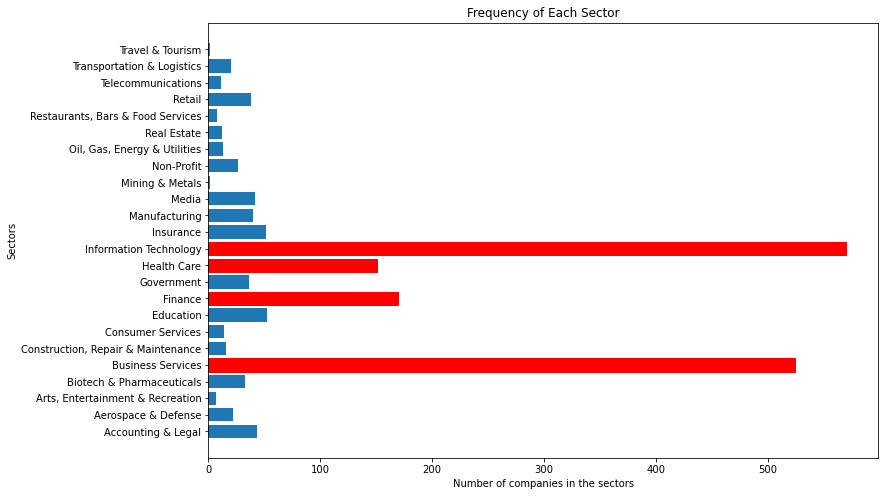

In [90]:
sector_count = data.groupby('Sector')['Job Title'].count()
del sector_count['-1']
plt.figure(figsize=(12,8))
barlist=plt.barh(sector_count.keys(), sector_count.values)
for i in [4,8,10,11]:
    barlist[i].set_color('r')
plt.title('Frequency of Each Sector')
plt.ylabel('Sectors')
plt.xlabel('Number of companies in the sectors')
plt.tick_params(axis='y', which='major', labelsize=10)

#plt.xticks(rotation=90)
plt.show()

## create different table in terms of different sector

In [4]:
df_bs = data[data.Sector=='Business Services']
#df_bs.head()

In [5]:
df_IT = data[data.Sector=='Information Technology']
#df_IT.head()

In [6]:
df_HC = data[data.Sector=='Health Care']
#df_HC.head()

In [7]:
df_F = data[data.Sector=='Finance']
#df_F.head()

# Data Cleaning

In [8]:
from nltk.util import bigrams
from nltk.corpus import stopwords
import string
import re
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

def clean_text(text, unigrams=True, punctuation=True):
    '''Assume text is of type string. Convert text into lowercase.
    Remove stopwords and punctuations. Tokenize text into unigrams/bigrams. 
    
    Args:
        text (str): text to be tokenized.
        unigrams (bool): tokenize text into unigrams if True, bigrams if False.
        punctuation (bool): remove punctuation if True. 
        
    Returns:
        a list of tokens.
    '''
    # Covnvert text into lowercase
    text = text.lower()
    text = text.replace('&amp;', '&')
    text = text.replace('\n', ' ')
    
    # Remove url(s) which is present in another column 
    text = re.sub(' https:\/\/[^\s]+', '', text)
    
    # Remove digits 
    table = str.maketrans(' ', ' ', '0123456789')
    text = text.translate(table)
    
    # Remove punctuations
    if punctuation == True:
        punctuations = string.punctuation + '‘’“”...'
        table = str.maketrans(' ', ' ', punctuations)
        text = text.translate(table)
        
    # Remove stopwords  
    eng_stop_words = stopwords.words('english')
    text = ' '.join([word for word in text.split() if word not in eng_stop_words])
    tokens = [token.lemma_ for token in nlp(text)
                  if not token.is_stop and not token.is_punct
                  and not token.like_num]
    if unigrams == False:
        # Tokenize texts into bigrams
        tokens = [''.join(bigram) for bigram in bigrams(tokens)]

    return tokens

In [9]:
# Clean the job description 
job_des = data['Job Description'].apply(clean_text)
job_des[0:5]

BS_des = df_bs['Job Description'].apply(clean_text)
IT_des = df_IT['Job Description'].apply(clean_text)
HC_des = df_HC['Job Description'].apply(clean_text)
F_des = df_F['Job Description'].apply(clean_text)

In [10]:
def count_tokens(text, desc=True):
    '''Count the frequency of each word given a list of tokens'''
    word_dict = {}
    
    for line in text:
        for token in line:
            if token in word_dict:
                word_dict[token] += 1
            elif token not in word_dict:
                word_dict[token] = 1
    
    if desc:
        word_dict = sorted(word_dict.items(), 
                           key = lambda entry: entry[1],
                           reverse = True)
    
    return word_dict 

In [11]:
# Remove contextual stop words 
word_count = count_tokens(job_des)
print(word_count[0:100])
context_sw=['datum','experience','business','data','work','team','skill','analysis','analyst','ability','year','include',
           'provide','require','process','analytic','requirement','job','information','knowledge','understand','etc','identify']
#context_sw = [word[0] for word in word_count[0:21]] # remove words until SQL
corpus = job_des.apply(lambda line: [token for token in line if token not in context_sw])
print(corpus[0:5])

[('datum', 17867), ('experience', 9621), ('work', 7615), ('business', 7111), ('data', 5382), ('team', 5017), ('skill', 4694), ('analysis', 4153), ('analyst', 3856), ('ability', 3691), ('report', 3653), ('management', 3614), ('year', 3561), ('support', 3379), ('system', 3250), ('include', 3223), ('provide', 3067), ('require', 3058), ('process', 3033), ('project', 2805), ('analytic', 2798), ('requirement', 2752), ('job', 2749), ('information', 2712), ('knowledge', 2678), ('develop', 2621), ('strong', 2606), ('opportunity', 2418), ('tool', 2388), ('need', 2291), ('sql', 2252), ('quality', 2245), ('solution', 2169), ('service', 2147), ('development', 2120), ('company', 2094), ('client', 2055), ('analyze', 2011), ('product', 1998), ('new', 1984), ('technology', 1976), ('database', 1950), ('technical', 1927), ('customer', 1828), ('position', 1819), ('degree', 1810), ('understand', 1771), ('design', 1762), ('create', 1717), ('perform', 1690), ('role', 1675), ('reporting', 1617), ('environment

In [12]:
BS_word_count = count_tokens(BS_des)
print(BS_word_count[0:50])

#BS_context_sw = [word[0] for word in BS_word_count[0:20]] # remove words until including work
BS_corpus = BS_des.apply(lambda line: [token for token in line if token not in context_sw])
print(BS_corpus[0:5])

[('datum', 3626), ('experience', 2104), ('work', 1702), ('business', 1405), ('data', 1202), ('skill', 1085), ('team', 1044), ('analyst', 918), ('analysis', 792), ('year', 755), ('support', 728), ('ability', 726), ('management', 708), ('job', 707), ('report', 695), ('client', 687), ('requirement', 676), ('include', 664), ('require', 657), ('project', 618), ('system', 618), ('provide', 592), ('process', 591), ('analytic', 587), ('strong', 571), ('opportunity', 555), ('knowledge', 549), ('sql', 527), ('tool', 511), ('develop', 510), ('solution', 503), ('company', 490), ('information', 475), ('development', 458), ('need', 431), ('quality', 430), ('technical', 422), ('new', 416), ('technology', 411), ('database', 391), ('service', 387), ('role', 385), ('degree', 372), ('product', 365), ('understand', 359), ('analyze', 356), ('environment', 352), ('position', 347), ('communication', 325), ('responsibility', 319)]
9     [riskifie, ai, platform, powering, ecommerce, ...
13    [know, know, mode

In [13]:
IT_word_count = count_tokens(IT_des)
print(IT_word_count[0:30])

#IT_context_sw = [word[0] for word in IT_word_count[0:24]] # remove words until including work
IT_corpus = IT_des.apply(lambda line: [token for token in line if token not in context_sw])
print(IT_corpus[0:5])

[('datum', 4365), ('experience', 2301), ('business', 1866), ('work', 1699), ('team', 1233), ('data', 1204), ('skill', 1026), ('analysis', 846), ('analyst', 842), ('year', 776), ('management', 765), ('ability', 741), ('system', 725), ('report', 704), ('provide', 662), ('requirement', 657), ('support', 650), ('analytic', 646), ('process', 642), ('job', 641), ('strong', 637), ('knowledge', 618), ('product', 616), ('project', 612), ('sql', 584), ('analyze', 570), ('include', 565), ('information', 557), ('develop', 550), ('opportunity', 545)]
2     [look, senior, love, mentorship, visualization...
3     [requisition, numberrr, remoteye, collaborate,...
19    [teacher, pay, teacher, tpt, unlocking, power,...
20    [note, apply, position, application, automatic...
26    [build, duolingo, newly, form, fpa, strategic,...
Name: Job Description, dtype: object


In [14]:
HC_word_count = count_tokens(HC_des)
print(HC_word_count[0:40])

#HC_context_sw = [word[0] for word in HC_word_count[0:3]] # remove words until including work
HC_corpus = HC_des.apply(lambda line: [token for token in line if token not in context_sw])
print(HC_corpus[0:5])

[('datum', 1513), ('experience', 722), ('work', 579), ('health', 541), ('data', 479), ('report', 462), ('analysis', 418), ('business', 397), ('skill', 359), ('include', 331), ('management', 327), ('analyst', 327), ('team', 324), ('ability', 320), ('system', 310), ('care', 302), ('year', 292), ('require', 285), ('information', 277), ('provide', 275), ('quality', 273), ('support', 272), ('develop', 270), ('research', 268), ('project', 267), ('healthcare', 257), ('need', 247), ('knowledge', 243), ('analytic', 237), ('database', 227), ('process', 226), ('position', 220), ('degree', 207), ('tool', 205), ('sql', 204), ('relate', 202), ('clinical', 196), ('requirement', 190), ('service', 188), ('opportunity', 180)]
1     [overview, analytical, technical, support, int...
10    [nyu, grossman, school, medicine, nation, topr...
12    [summary, clinical, research, pediatric, bmt, ...
27    [ro, found, ro, patientdriven, telehealth, com...
38    [nyu, grossman, school, medicine, nation, topr...
Na

In [15]:
F_word_count = count_tokens(F_des)
print(F_word_count[0:50])

#F_context_sw = [word[0] for word in F_word_count[0:40]] # remove words until including work
F_corpus = F_des.apply(lambda line: [token for token in line if token not in context_sw])
print(F_corpus[0:5])

[('datum', 1545), ('business', 831), ('experience', 769), ('work', 690), ('team', 583), ('data', 487), ('management', 449), ('skill', 410), ('support', 355), ('ability', 354), ('financial', 327), ('process', 322), ('include', 320), ('analyst', 313), ('analysis', 308), ('report', 308), ('provide', 294), ('opportunity', 284), ('develop', 268), ('system', 265), ('year', 264), ('information', 262), ('technology', 261), ('service', 257), ('analytic', 255), ('require', 250), ('knowledge', 249), ('tool', 247), ('need', 243), ('solution', 239), ('quality', 238), ('client', 233), ('strong', 221), ('development', 220), ('project', 218), ('requirement', 210), ('new', 209), ('understand', 207), ('job', 205), ('perform', 197), ('role', 193), ('reporting', 190), ('risk', 185), ('design', 181), ('company', 181), ('customer', 176), ('issue', 174), ('create', 172), ('application', 170), ('environment', 166)]
5     [cubist, cubist, systematic, strategy, world, ...
6     [sigma, different, kind, investme

# Topic Model

## import library

In [64]:
from gensim.corpora import Dictionary, csvcorpus
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim_models

C:\Users\35196\anaconda3\envs\smm635_gp\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


## Create dictionary and corpus objects for gensim lda

In [17]:
text_dict = Dictionary(corpus)
lda_corpus = [text_dict.doc2bow(text) for text in corpus]
print(text_dict)

Dictionary(20781 unique tokens: ['able', 'access', 'achievable', 'action', 'additional']...)


In [18]:
BS_text_dict = Dictionary(BS_corpus)
BS_lda_corpus = [BS_text_dict.doc2bow(text) for text in BS_corpus]
print(BS_text_dict)

Dictionary(7686 unique tokens: ['account', 'age', 'ai', 'algorithm', 'analytical']...)


In [19]:
IT_text_dict = Dictionary(IT_corpus)
IT_lda_corpus = [IT_text_dict.doc2bow(text) for text in IT_corpus]
print(IT_text_dict)

Dictionary(8543 unique tokens: ['account', 'act', 'actionable', 'advanced', 'advisor']...)


In [20]:
HC_text_dict = Dictionary(HC_corpus)
HC_lda_corpus = [HC_text_dict.doc2bow(text) for text in HC_corpus]
print(HC_text_dict)

Dictionary(4738 unique tokens: ['access', 'accomplish', 'accordingly', 'accuracy', 'accurate']...)


In [21]:
F_text_dict = Dictionary(F_corpus)
F_lda_corpus = [F_text_dict.doc2bow(text) for text in F_corpus]
print(F_text_dict)

Dictionary(5302 unique tokens: ['access', 'anomaly', 'arrangement', 'assess', 'asset']...)


## Train an LDA model and visualize the result

In [22]:

def plot_top_words(model, num_topics, num_words, title, row_no, column_no, figsize=(20, 30)):
    '''Plot top words of each topic given an LDA model'''
    topics = model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
    
    output = []
    for i, topic in topics:
        for word, weight in topic:
            output.append([word, i, weight])
    output = pd.DataFrame(output, columns=['word', 'topic_id', 'importance'])     
       
    fig, axes = plt.subplots(row_no, column_no, figsize=figsize, dpi=160)
    for i, ax in enumerate(axes.flatten()):
        ax.barh(y='word', width="importance", data=output.loc[output.topic_id==i, :], label='Weights')    
        ax.set_title('Topic: ' + str(i), fontsize=16)
        ax.invert_yaxis()
            
    fig.tight_layout(w_pad=2) # adjust the width of padding between subplots 
    fig.suptitle(title, fontsize=22, y=1.05)    
    plt.show()

## Using coherance value to select the optimal number of topics

In [33]:
# define function
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    -----------
    dictionary : Gensim dictionary
    corpus     : Gensim corpus
    texts      : List of input texts
    limit      : Max number of topics

    Returns:
    --------
    model_list       : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model
                       with respective number of topics
    """
    coherence_values = []
    model_list = []
    mallet_path = MALLET_PATH
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path,
                                                 corpus=corpus,
                                                 num_topics=num_topics,
                                                 id2word=dictionary,
                                                 random_seed=123)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [34]:
# collect coherence scores as the number of retained topics change
LIMIT, START, STEP = 30, 1, 1
MODEL_LIST, COHER_VALS = compute_coherence_values(dictionary=BS_text_dict ,
                                                  corpus=BS_lda_corpus,
                                                  texts=BS_corpus,
                                                  start=START,
                                                  limit=LIMIT,
                                                  step=STEP)

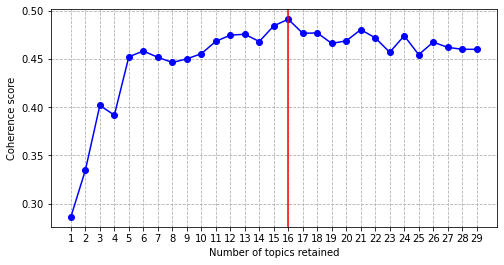

In [42]:
# plot collected coherence scores data

# data series
X = range(START, LIMIT, STEP)
Y = COHER_VALS

# create figure
FIG = plt.figure(figsize=(8, 4))
AX = FIG.add_subplot(1, 1, 1)

# plot data
AX.plot(X, Y, marker='o', color='b', ls='-')

# axes
AX.set_xlabel("Number of topics retained")
AX.set_ylabel("Coherence score")
AX.set_xticks(np.arange(1, 30, 1))

# reference line
AX.axvline(x=16, ymin=0, ymax=1, color='r')

# grid
AX.grid(True, ls='--')


plt.show()

In [37]:
# collect coherence scores as the number of retained topics change

MODEL_LIST1, COHER_VALS1 = compute_coherence_values(dictionary=IT_text_dict ,
                                                  corpus=IT_lda_corpus,
                                                  texts=IT_corpus,
                                                  start=START,
                                                  limit=LIMIT,
                                                  step=STEP)

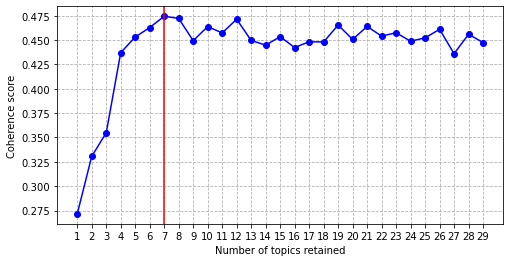

In [40]:
# plot collected coherence scores data

# data series
X = range(START, LIMIT, STEP)
Y = COHER_VALS1

# create figure
FIG = plt.figure(figsize=(8, 4))
AX = FIG.add_subplot(1, 1, 1)

# plot data
AX.plot(X, Y, marker='o', color='b', ls='-')

# axes
AX.set_xlabel("Number of topics retained")
AX.set_ylabel("Coherence score")
AX.set_xticks(np.arange(1, 30, 1))

# reference line
AX.axvline(x=7, ymin=0, ymax=1, color='r')

# grid
AX.grid(True, ls='--')


plt.show()

In [43]:
# collect coherence scores as the number of retained topics change

MODEL_LIST2, COHER_VALS2 = compute_coherence_values(dictionary=HC_text_dict ,
                                                  corpus=HC_lda_corpus,
                                                  texts=HC_corpus,
                                                  start=START,
                                                  limit=LIMIT,
                                                  step=STEP)

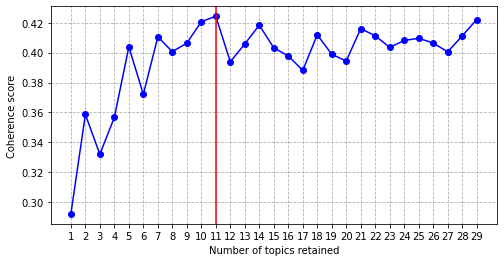

In [45]:
# plot collected coherence scores data

# data series
X = range(START, LIMIT, STEP)
Y = COHER_VALS2

# create figure
FIG = plt.figure(figsize=(8, 4))
AX = FIG.add_subplot(1, 1, 1)

# plot data
AX.plot(X, Y, marker='o', color='b', ls='-')

# axes
AX.set_xlabel("Number of topics retained")
AX.set_ylabel("Coherence score")
AX.set_xticks(np.arange(1, 30, 1))

# reference line
AX.axvline(x=11, ymin=0, ymax=1, color='r')

# grid
AX.grid(True, ls='--')


plt.show()

In [46]:
# collect coherence scores as the number of retained topics change

MODEL_LIST3, COHER_VALS3 = compute_coherence_values(dictionary=F_text_dict ,
                                                  corpus=F_lda_corpus,
                                                  texts=F_corpus,
                                                  start=START,
                                                  limit=LIMIT,
                                                  step=STEP)

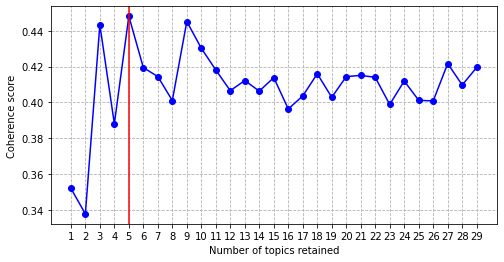

In [48]:
# plot collected coherence scores data

# data series
X = range(START, LIMIT, STEP)
Y = COHER_VALS3

# create figure
FIG = plt.figure(figsize=(8, 4))
AX = FIG.add_subplot(1, 1, 1)

# plot data
AX.plot(X, Y, marker='o', color='b', ls='-')

# axes
AX.set_xlabel("Number of topics retained")
AX.set_ylabel("Coherence score")
AX.set_xticks(np.arange(1, 30, 1))

# reference line
AX.axvline(x=5, ymin=0, ymax=1, color='r')

# grid
AX.grid(True, ls='--')


plt.show()

## Business Service Topic modeling using optimal number of topics

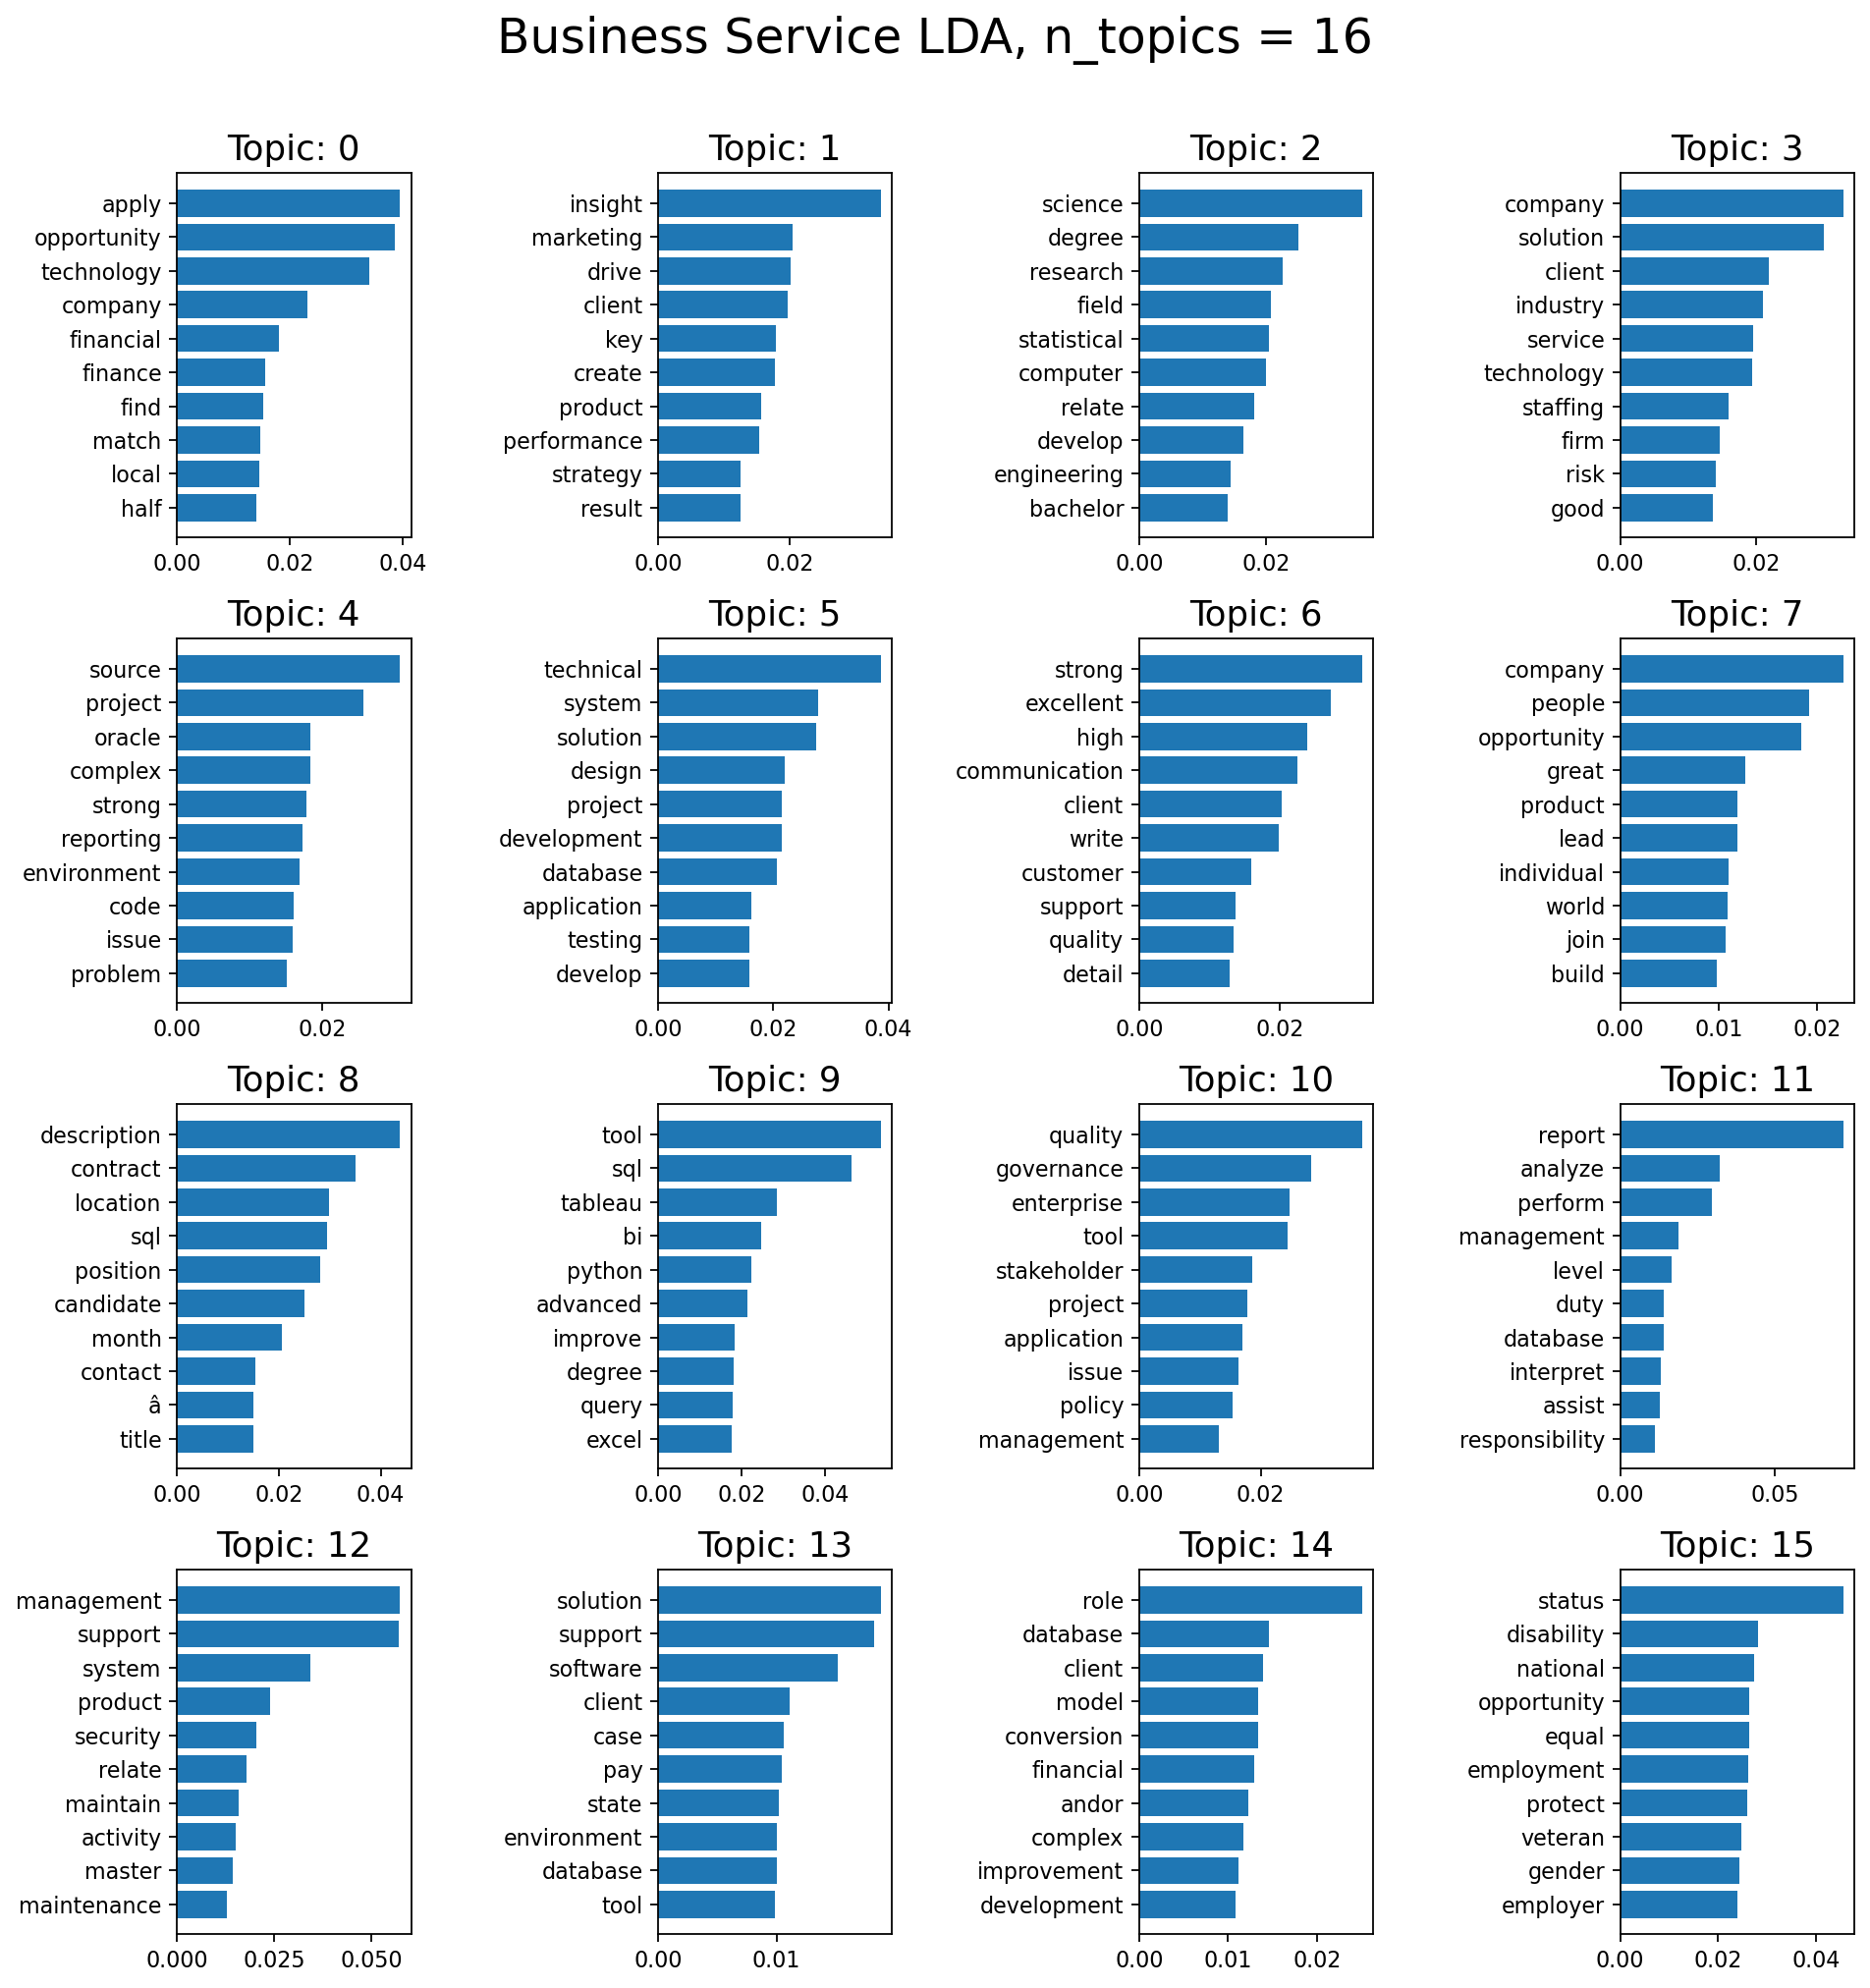

In [83]:
num_topics = 16
num_words = 10
row_no = 4
column_no = 4
figsize=(12, 12)
BS_LDA_MALLET = gensim.models.wrappers.LdaMallet(MALLET_PATH,
                                              corpus=BS_lda_corpus,
                                              num_topics=num_topics,
                                              id2word=BS_text_dict,
                                              random_seed=123)
BS_LDA_MALLET.print_topics(num_topics=num_topics, num_words=num_words)
title = 'Business Service LDA, n_topics = 16'
plot_top_words(model=BS_LDA_MALLET, num_topics=num_topics, num_words=num_words, 
               title=title, row_no=row_no, column_no=column_no, figsize=figsize)

In [75]:
BS_LDA_MALLET.print_topics(num_topics = 16, num_words=5)

[(0,
  '0.040*"apply" + 0.039*"opportunity" + 0.034*"technology" + 0.023*"company" + 0.018*"financial"'),
 (1,
  '0.034*"insight" + 0.020*"marketing" + 0.020*"drive" + 0.020*"client" + 0.018*"key"'),
 (2,
  '0.035*"science" + 0.025*"degree" + 0.023*"research" + 0.021*"field" + 0.020*"statistical"'),
 (3,
  '0.033*"company" + 0.030*"solution" + 0.022*"client" + 0.021*"industry" + 0.019*"service"'),
 (4,
  '0.031*"source" + 0.026*"project" + 0.018*"oracle" + 0.018*"complex" + 0.018*"strong"'),
 (5,
  '0.039*"technical" + 0.028*"system" + 0.027*"solution" + 0.022*"design" + 0.022*"project"'),
 (6,
  '0.032*"strong" + 0.027*"excellent" + 0.024*"high" + 0.023*"communication" + 0.020*"client"'),
 (7,
  '0.023*"company" + 0.019*"people" + 0.018*"opportunity" + 0.013*"great" + 0.012*"lead"'),
 (8,
  '0.044*"description" + 0.035*"contract" + 0.030*"location" + 0.029*"sql" + 0.028*"position"'),
 (9,
  '0.053*"tool" + 0.046*"sql" + 0.029*"tableau" + 0.025*"bi" + 0.022*"python"'),
 (10,
  '0.037*"

In [76]:
BS_LDA_MALLET_G = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(BS_LDA_MALLET)

In [77]:

# ignore warnings coming from pyLDAvis
import warnings
warnings.filterwarnings('ignore')

# visualizing the outcome of the retained model -- this takes time
pyLDAvis.enable_notebook()
BS_DATA_VIS = pyLDAvis.gensim_models.prepare(BS_LDA_MALLET_G, BS_lda_corpus, BS_text_dict, sort_topics=False)
BS_DATA_VIS

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.207588 -0.128757       1        1  5.385292
1      0.066649  0.044774       2        1  7.195558
2      0.115979  0.029566       3        1  7.078138
3     -0.179448 -0.107057       4        1  6.210050
4      0.175729 -0.034679       5        1  6.065755
5      0.160607 -0.122311       6        1  6.832252
6      0.000912  0.208207       7        1  6.415732
7     -0.176910 -0.045407       8        1  6.725627
8     -0.144564  0.290836       9        1  4.996159
9      0.002931  0.251870      10        1  5.453015
10     0.127701 -0.063623      11        1  6.387585
11     0.114013 -0.054832      12        1  6.672995
12     0.130052 -0.035063      13        1  6.281297
13     0.014830 -0.081862      14        1  6.682175
14     0.039357 -0.035112      15        1  5.573074
15    -0.240250 -0.116550      16        1  6.045295, topic_info=           Term        Freq       Total Category  logprob  loglift
334      report  711.000000  711.000000  Default  30.0000  30.0000
200        tool  540.000000  540.000000  Default  29.0000  29.0000
297  management  731.000000  731.000000  Default  28.0000  28.0000
184         sql  552.000000  552.000000  Default  27.0000  27.0000
191     support  758.000000  758.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
910      search   58.943229  101.708742  Topic16  -4.6782   2.2604
111     medical   51.575325  108.270597  Topic16  -4.8117   2.0643
779      action   47.365094   77.826303  Topic16  -4.8968   2.3093
452    bachelor   56.838113  213.882269  Topic16  -4.7145   1.4807
20       client   53.680440  721.353977  Topic16  -4.7717   0.2078

[1382 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2326      2  0.974154      ab
2151     15  0.978382  accept
1008      1  0.369376  access
1008     11  0.356639  access
1008     14  0.197425  access
...     ...       ...     ...
4084      4  0.980062      zs
3077      1  1.029431       ©
2805      8  0.996050       ®
2847      9  1.004979       â
3902     15  1.000618       ●

[2147 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

In [80]:
pyLDAvis.save_html(BS_DATA_VIS, 'BS.html')

## Information Technology Topic modeling using optimal number of topics

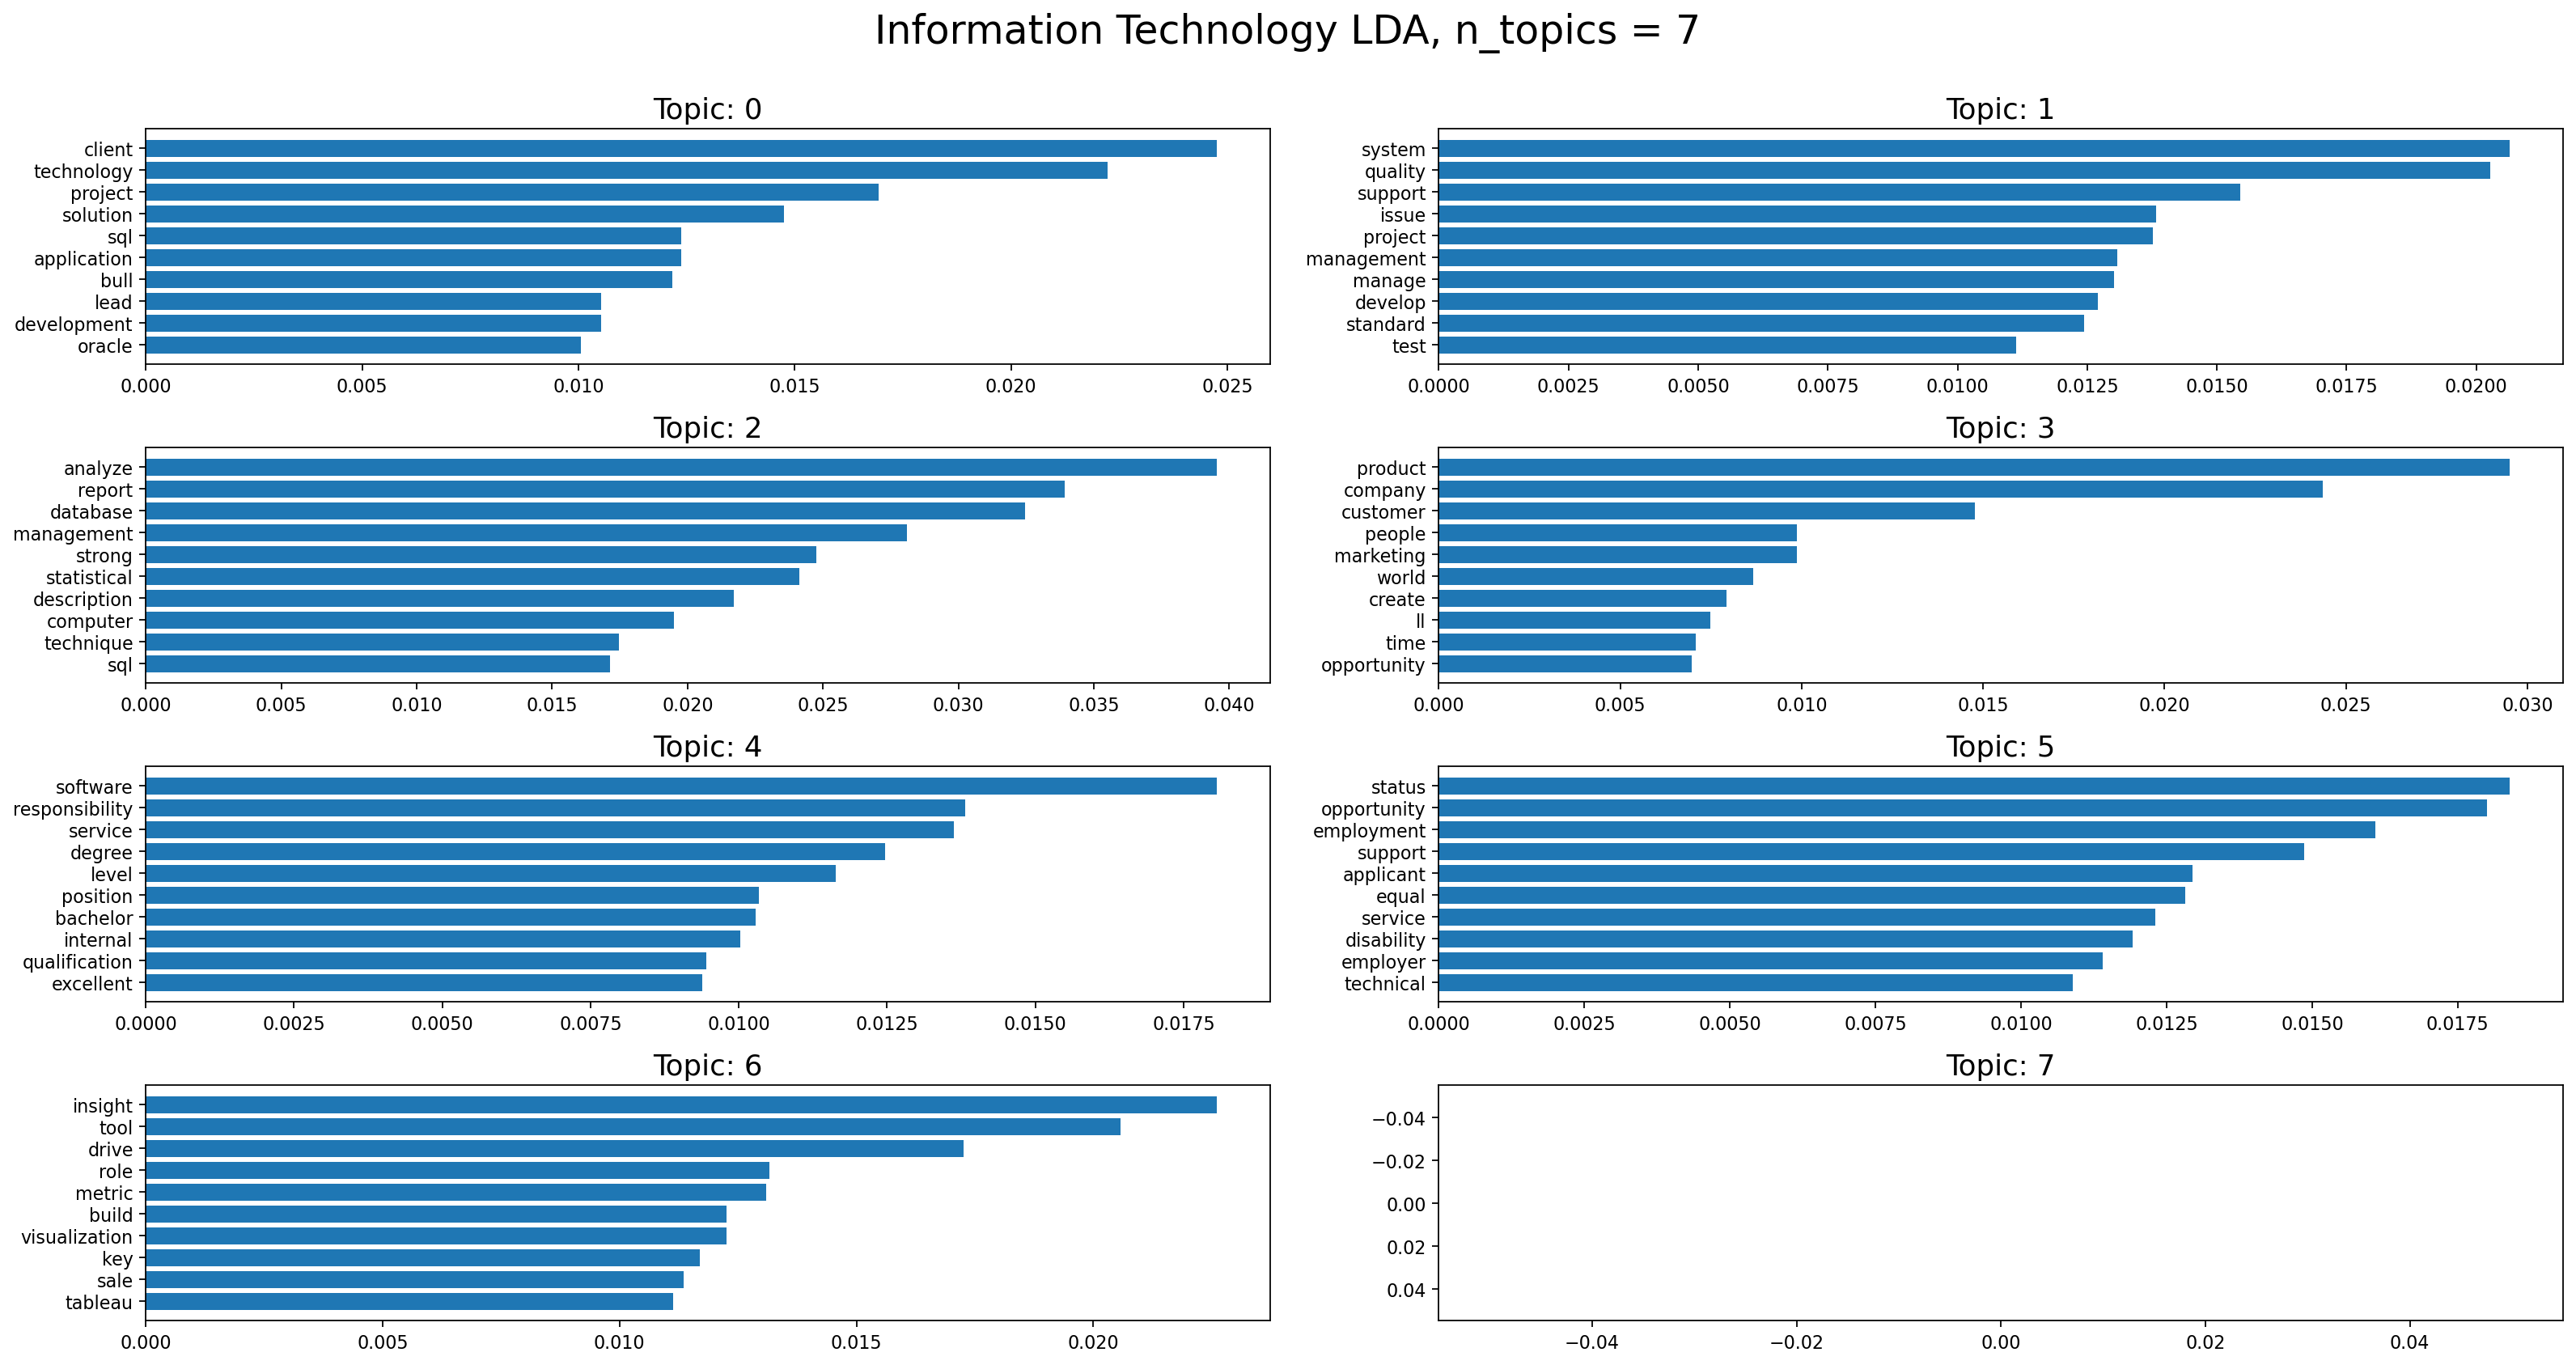

In [82]:
num_topics = 7
num_words = 10
row_no = 4
column_no = 2
figsize=(20, 10)
IT_LDA_MALLET = gensim.models.wrappers.LdaMallet(MALLET_PATH,
                                              corpus=IT_lda_corpus,
                                              num_topics=num_topics,
                                              id2word=IT_text_dict,
                                              random_seed=123)
IT_LDA_MALLET.print_topics(num_topics=num_topics, num_words=num_words)
title = f'Information Technology LDA, n_topics = {num_topics}'
plot_top_words(model=IT_LDA_MALLET, num_topics=num_topics, num_words=num_words, 
               title=title, row_no=row_no, column_no=column_no, figsize=figsize)

In [71]:
IT_LDA_MALLET.print_topics(num_topics = 7, num_words=5)

[(0,
  '0.025*"client" + 0.022*"technology" + 0.017*"project" + 0.015*"solution" + 0.012*"sql"'),
 (1,
  '0.021*"system" + 0.020*"quality" + 0.015*"support" + 0.014*"issue" + 0.014*"project"'),
 (2,
  '0.040*"analyze" + 0.034*"report" + 0.032*"database" + 0.028*"management" + 0.025*"strong"'),
 (3,
  '0.030*"product" + 0.024*"company" + 0.015*"customer" + 0.010*"marketing" + 0.010*"people"'),
 (4,
  '0.018*"software" + 0.014*"responsibility" + 0.014*"service" + 0.012*"degree" + 0.012*"level"'),
 (5,
  '0.018*"status" + 0.018*"opportunity" + 0.016*"employment" + 0.015*"support" + 0.013*"applicant"'),
 (6,
  '0.023*"insight" + 0.021*"tool" + 0.017*"drive" + 0.013*"role" + 0.013*"metric"')]

In [72]:
IT_LDA_MALLET_G = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(IT_LDA_MALLET)

In [73]:
# ignore warnings coming from pyLDAvis
import warnings
warnings.filterwarnings('ignore')

# visualizing the outcome of the retained model -- this takes time
pyLDAvis.enable_notebook()
IT_DATA_VIS = pyLDAvis.gensim_models.prepare(IT_LDA_MALLET_G, IT_lda_corpus, IT_text_dict, sort_topics=False)
IT_DATA_VIS

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.070152 -0.175073       1        1  13.542772
1     -0.129714 -0.088876       2        1  14.172261
2     -0.333171 -0.084078       3        1  12.201528
3      0.282632 -0.179960       4        1  15.902212
4      0.003144  0.304251       5        1  14.015192
5      0.160219  0.161904       6        1  14.366760
6     -0.053261  0.061833       7        1  15.799275, topic_info=           Term        Freq       Total Category  logprob  loglift
9       analyze  564.000000  564.000000  Default  30.0000  30.0000
505    database  504.000000  504.000000  Default  29.0000  29.0000
179      report  709.000000  709.000000  Default  28.0000  28.0000
165     product  653.000000  653.000000  Default  27.0000  27.0000
369  management  776.000000  776.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
199         sql  139.265541  596.466772   Topic7  -4.8884   0.3906
146   operation  115.361754  256.269573   Topic7  -5.0767   1.0470
425    solution  127.833295  562.262299   Topic7  -4.9740   0.3640
138       model  118.479640  374.333379   Topic7  -5.0500   0.6948
187     science  117.440344  350.603066   Topic7  -5.0588   0.7515

[556 rows x 6 columns], token_table=      Topic      Freq                    Term
term                                         
237       5  0.949113                   abate
1291      5  1.004401                  access
465       6  0.998718           accommodation
0         5  1.007222                 account
239       5  1.016906          accountability
...     ...       ...                     ...
706       6  0.132226                   write
1210      1  1.002670                 writing
235       1  0.953759  wwwsquarespacecomabout
783       3  1.010059                      xp
1674      2  0.994934                       â

[739 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7])

In [79]:
pyLDAvis.save_html(IT_DATA_VIS, 'IT.html')

## Health Care Topic modeling using optimal number of topics

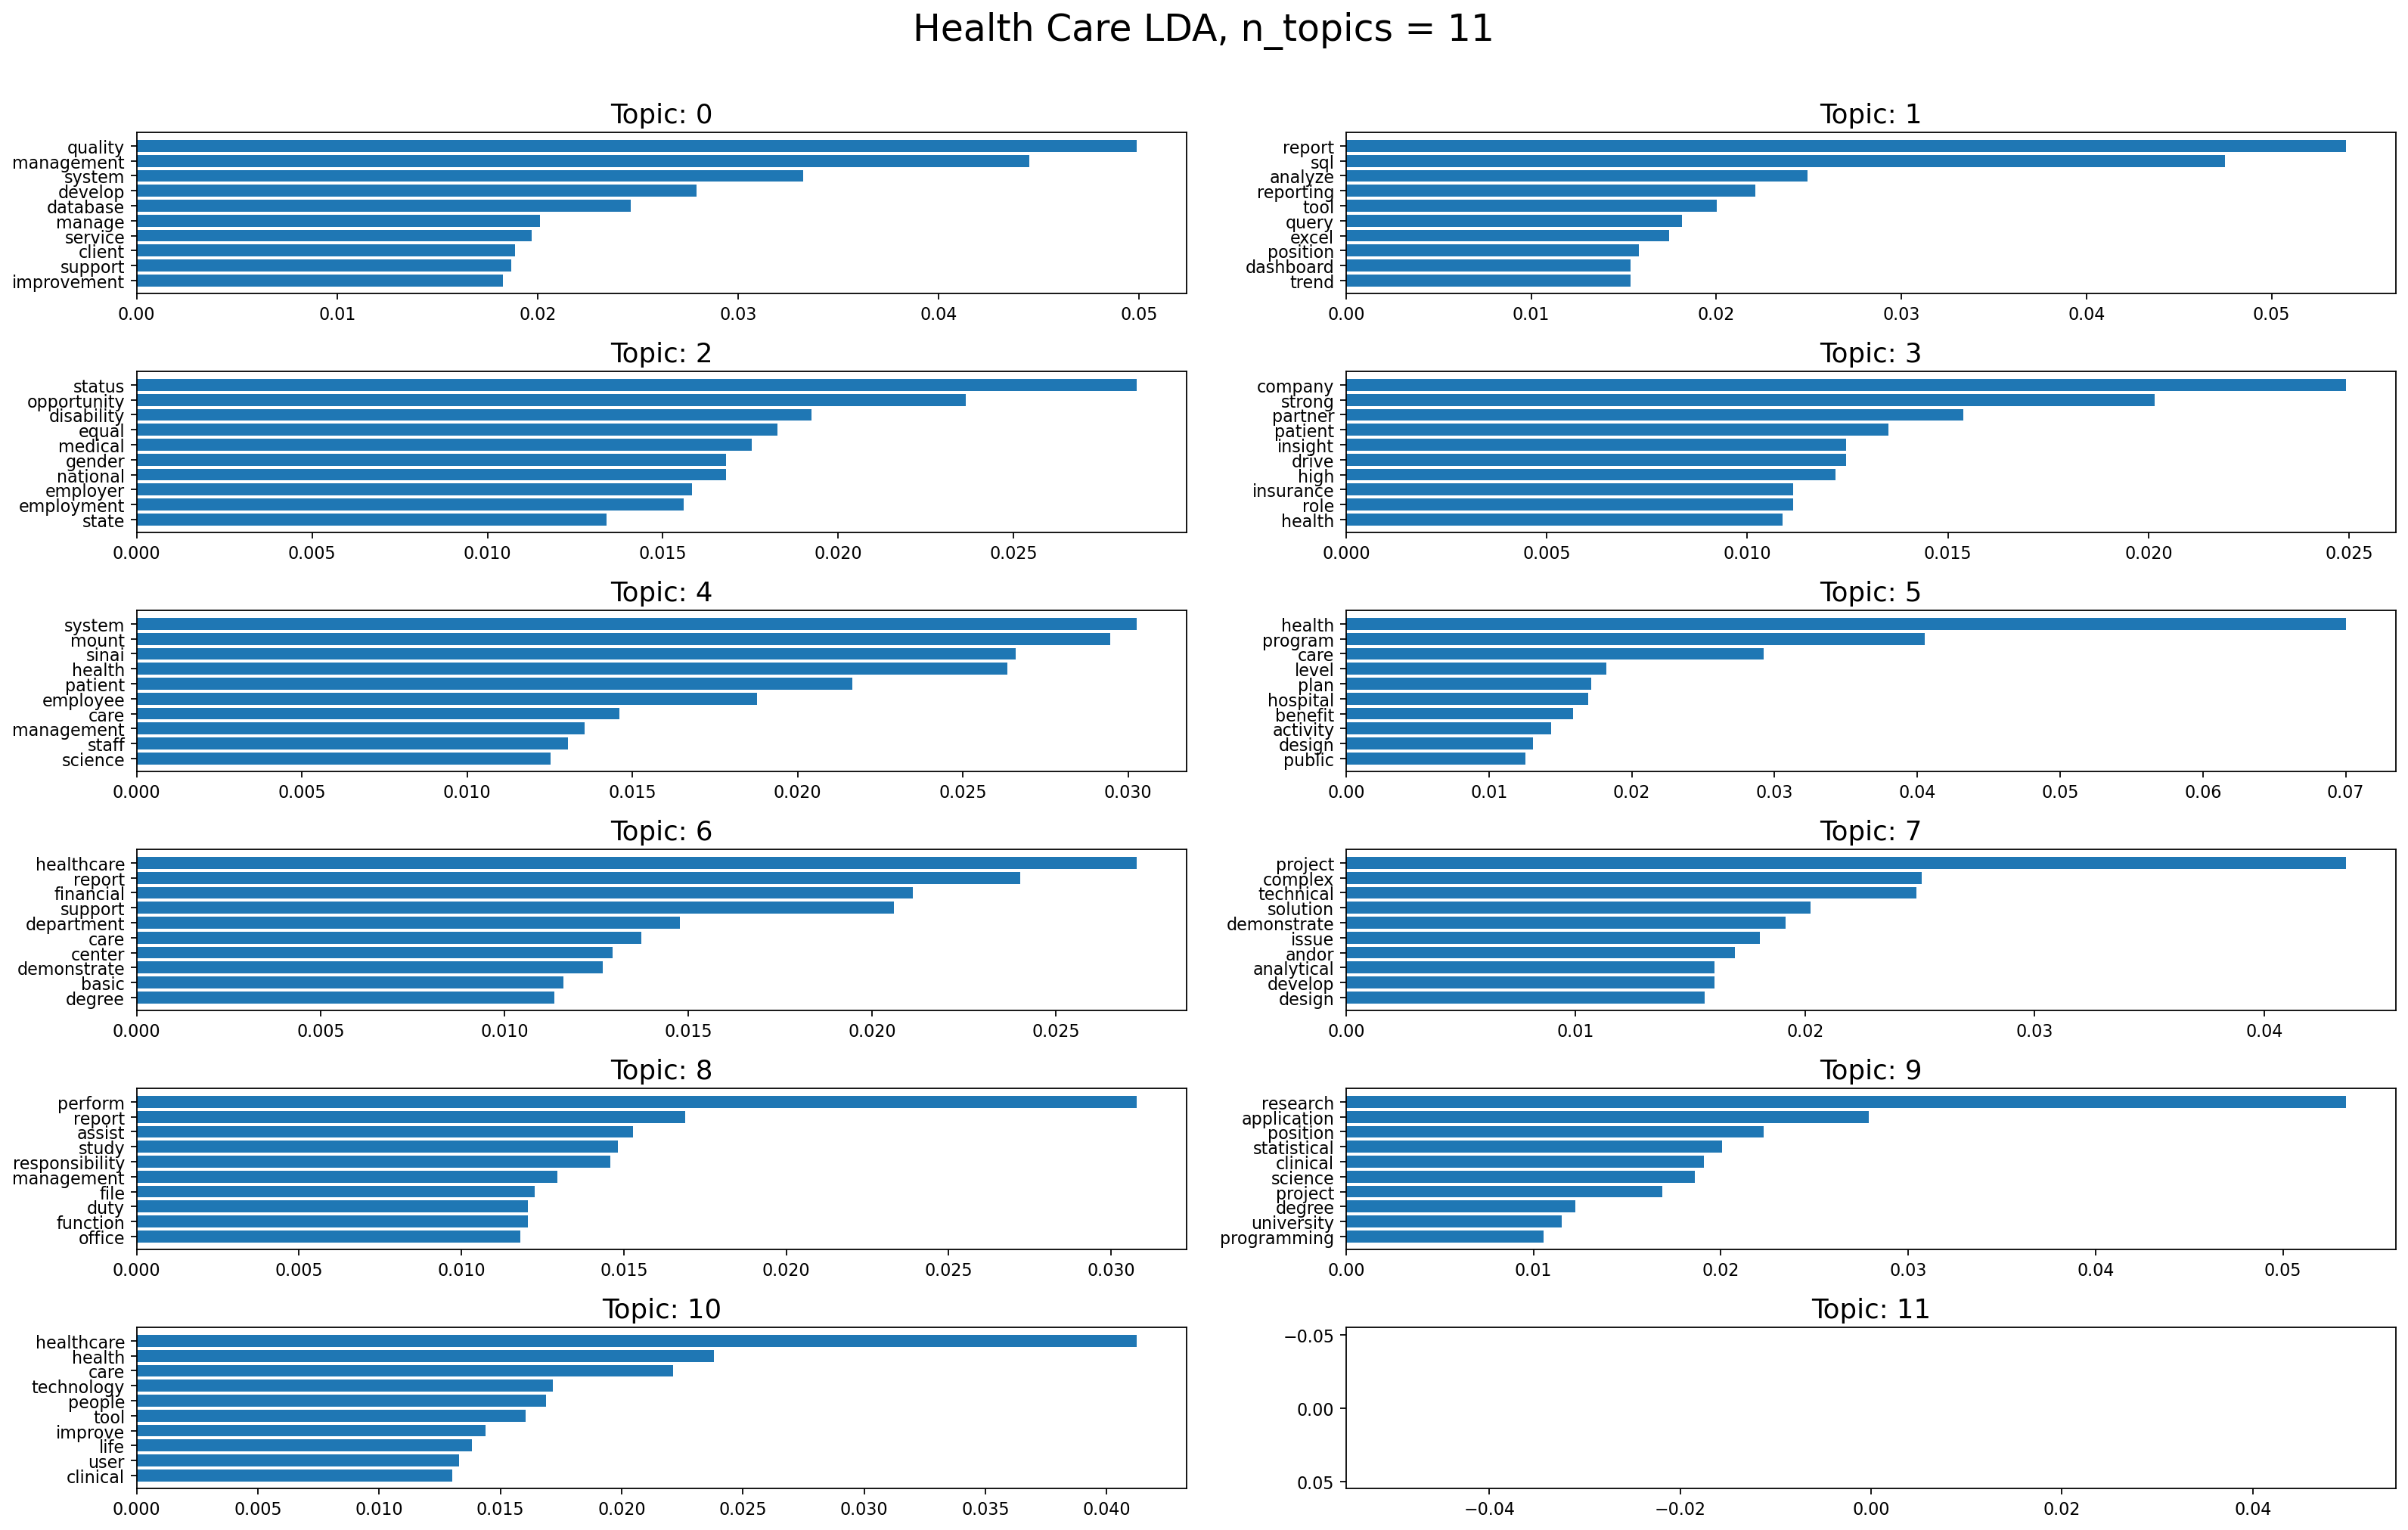

In [66]:
num_topics = 11
num_words = 10
row_no = 6
column_no = 2
figsize=(20, 12)
HC_LDA_MALLET = gensim.models.wrappers.LdaMallet(MALLET_PATH,
                                              corpus=HC_lda_corpus,
                                              num_topics=num_topics,
                                              id2word=HC_text_dict,
                                              random_seed=123)
HC_LDA_MALLET.print_topics(num_topics=num_topics, num_words=num_words)
title = f'Health Care LDA, n_topics = {num_topics}'
plot_top_words(model=HC_LDA_MALLET, num_topics=num_topics, num_words=num_words, 
               title=title, row_no=row_no, column_no=column_no, figsize=figsize)

In [67]:
HC_LDA_MALLET.print_topics(num_topics = 11, num_words=5)

[(0,
  '0.050*"quality" + 0.045*"management" + 0.033*"system" + 0.028*"develop" + 0.025*"database"'),
 (1,
  '0.054*"report" + 0.047*"sql" + 0.025*"analyze" + 0.022*"reporting" + 0.020*"tool"'),
 (2,
  '0.029*"status" + 0.024*"opportunity" + 0.019*"disability" + 0.018*"equal" + 0.018*"medical"'),
 (3,
  '0.025*"company" + 0.020*"strong" + 0.015*"partner" + 0.014*"patient" + 0.012*"insight"'),
 (4,
  '0.030*"system" + 0.029*"mount" + 0.027*"sinai" + 0.026*"health" + 0.022*"patient"'),
 (5,
  '0.070*"health" + 0.041*"program" + 0.029*"care" + 0.018*"level" + 0.017*"plan"'),
 (6,
  '0.027*"healthcare" + 0.024*"report" + 0.021*"financial" + 0.021*"support" + 0.015*"department"'),
 (7,
  '0.044*"project" + 0.025*"complex" + 0.025*"technical" + 0.020*"solution" + 0.019*"demonstrate"'),
 (8,
  '0.031*"perform" + 0.017*"report" + 0.015*"assist" + 0.015*"study" + 0.015*"responsibility"'),
 (9,
  '0.053*"research" + 0.028*"application" + 0.022*"position" + 0.020*"statistical" + 0.019*"clinical"'

In [68]:
HC_LDA_MALLET_G = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(HC_LDA_MALLET)

In [69]:
# ignore warnings coming from pyLDAvis
import warnings
warnings.filterwarnings('ignore')

# visualizing the outcome of the retained model -- this takes time
pyLDAvis.enable_notebook()
HC_DATA_VIS = pyLDAvis.gensim_models.prepare(HC_LDA_MALLET_G, HC_lda_corpus, HC_text_dict, sort_topics=False)
HC_DATA_VIS

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.011448  0.209210       1        1  10.551777
1     -0.070504  0.145431       2        1   9.399872
2     -0.202227 -0.345123       3        1   8.968069
3      0.237295 -0.118143       4        1   8.397009
4     -0.004164  0.062384       5        1   8.533120
5      0.083223  0.002718       6        1   8.777954
6      0.102158  0.071552       7        1   8.428123
7      0.038512  0.019655       8        1  10.055732
8     -0.233683  0.129272       9        1   9.562242
9     -0.167161 -0.084552      10        1   9.174405
10     0.227999 -0.092405      11        1   8.151699, topic_info=         Term        Freq       Total Category  logprob  loglift
81     health  570.000000  570.000000  Default  30.0000  30.0000
166    report  477.000000  477.000000  Default  29.0000  29.0000
155   quality  278.000000  278.000000  Default  28.0000  28.0000
169  research  282.000000  282.000000  Default  27.0000  27.0000
185       sql  209.000000  209.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
193   support   49.840804  282.024653  Topic11  -4.3424   0.7738
493   outcome   31.813279   87.190423  Topic11  -4.7914   1.4987
866   service   34.994607  194.957055  Topic11  -4.6961   0.7894
666      role   27.571509   86.177749  Topic11  -4.9345   1.3673
177   science   27.571509  158.043599  Topic11  -4.9345   0.7609

[901 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
214      10  0.947081      abstract
541       9  0.961164    accessible
1458      9  0.961164        accord
777       4  1.005764       account
778       7  1.009097    accounting
...     ...       ...           ...
1351      5  1.003474          york
982      11  1.005869             ®
1578      2  0.971883        •build
1581      2  0.971883  •demonstrate
2263      2  0.991717             

[1247 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

## Finance Topic modeling using optimal number of topics

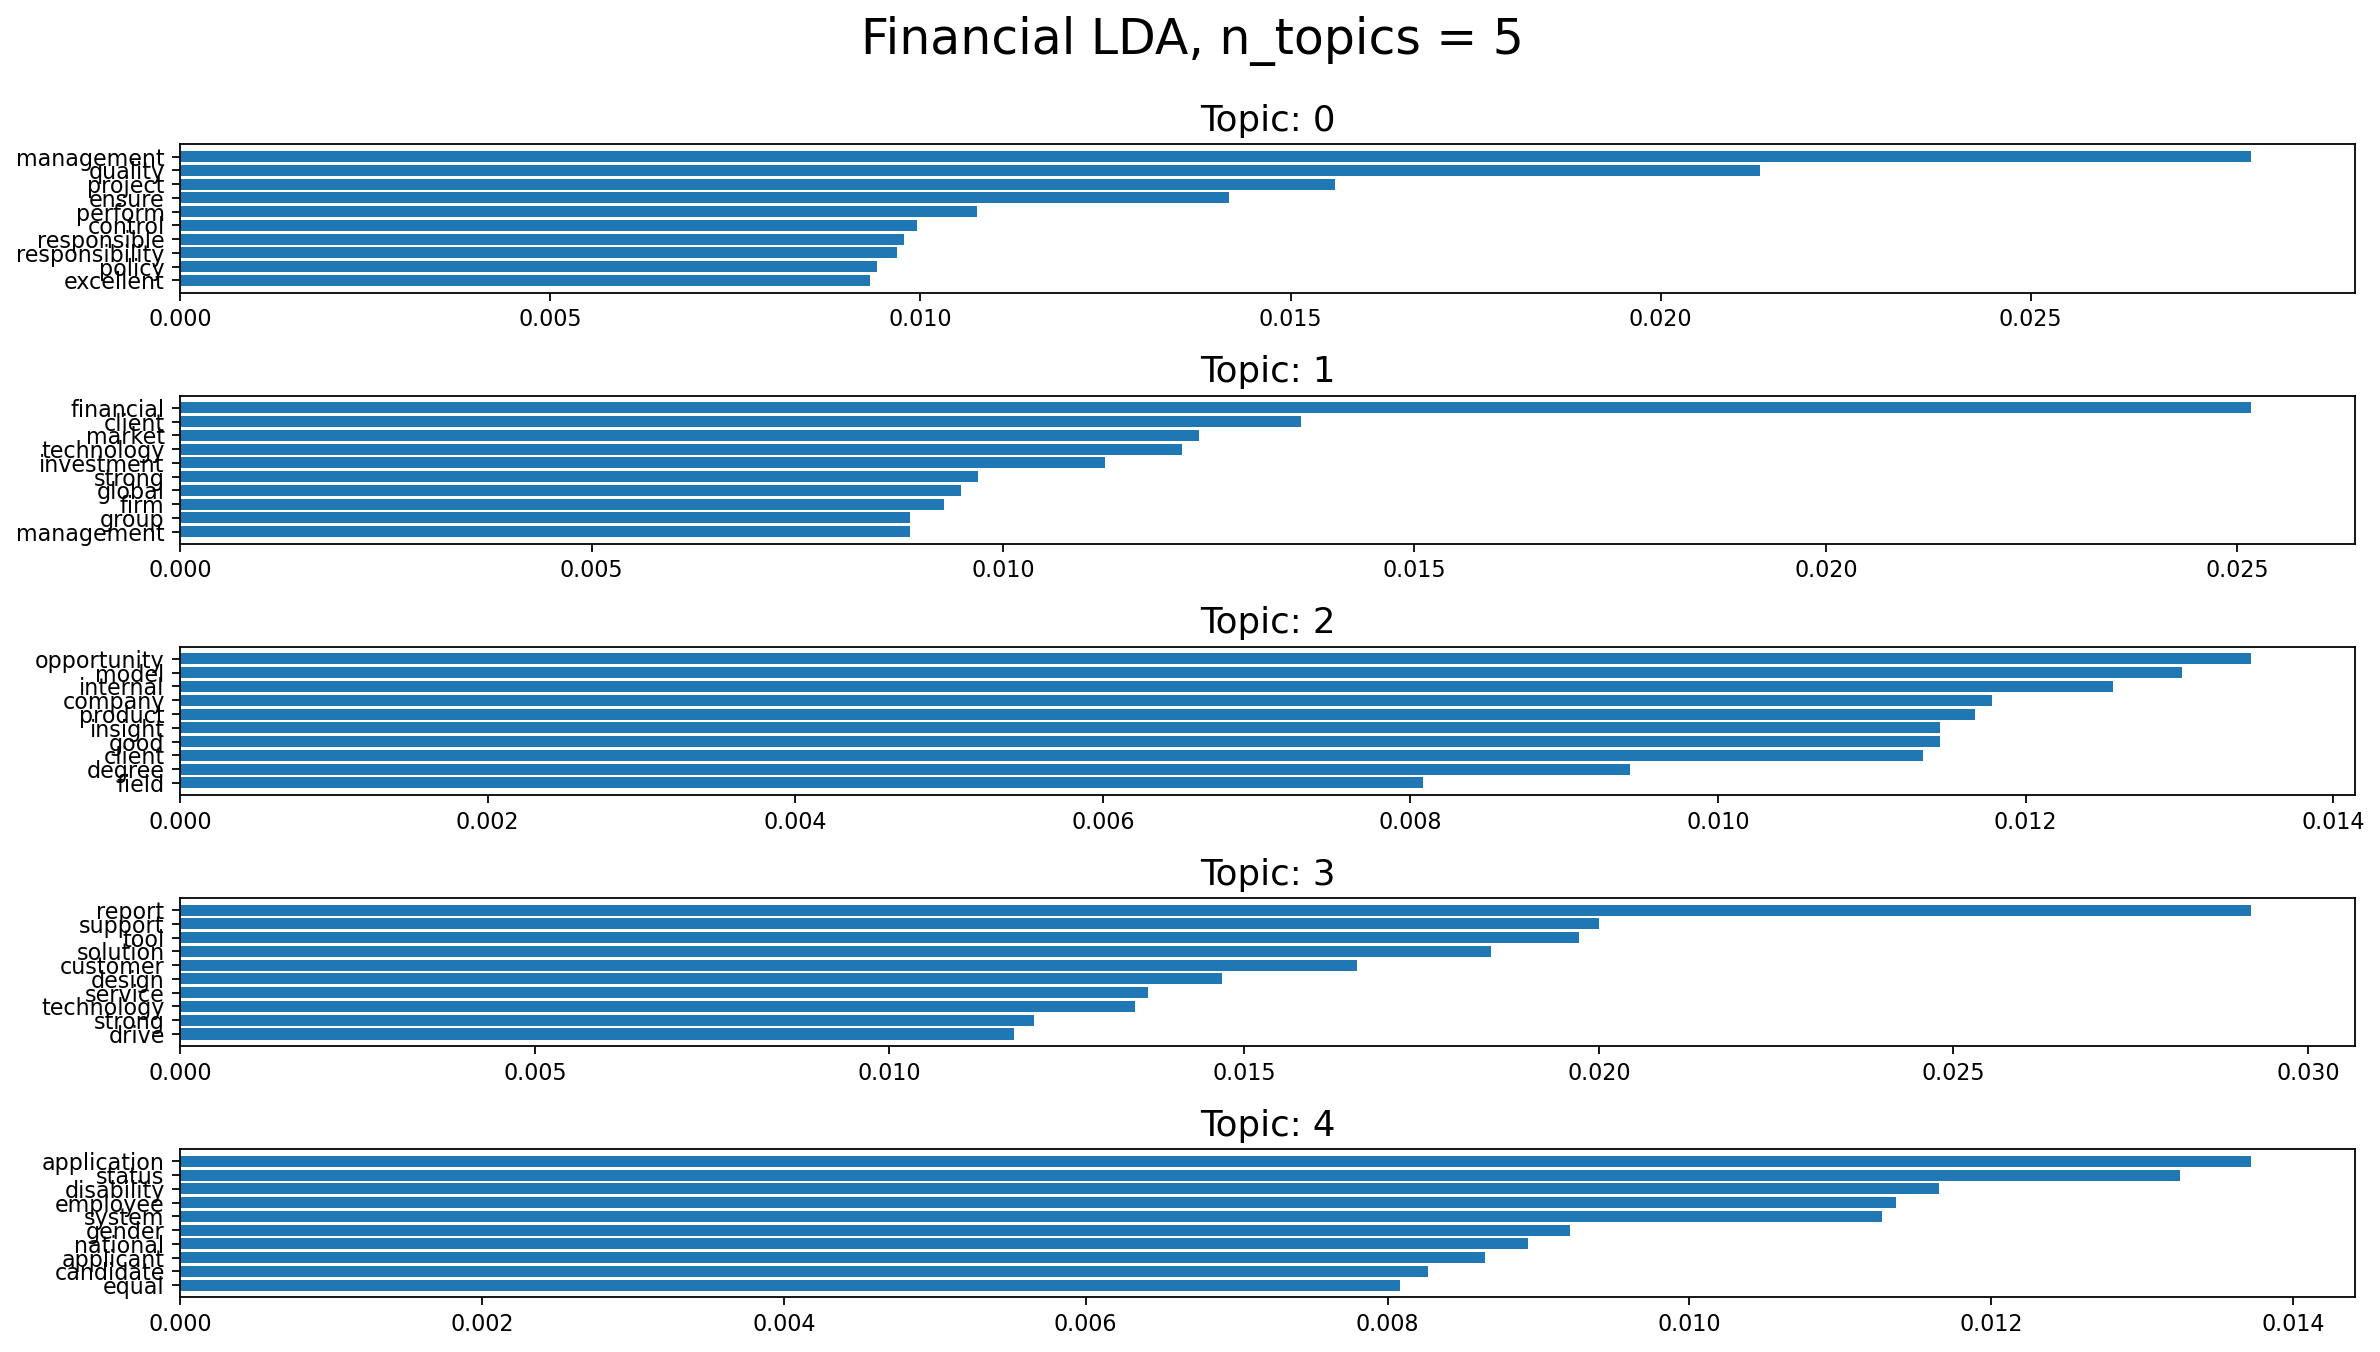

In [81]:
num_topics = 5
num_words = 10
row_no = 5
column_no = 1
figsize=(15, 8)
F_LDA_MALLET = gensim.models.wrappers.LdaMallet(MALLET_PATH,
                                              corpus=F_lda_corpus,
                                              num_topics=num_topics,
                                              id2word=F_text_dict,
                                              random_seed=123)

F_LDA_MALLET.print_topics(num_topics=num_topics, num_words=num_words)
title = f'Financial LDA, n_topics = {num_topics}'
plot_top_words(model=F_LDA_MALLET, num_topics=num_topics, num_words=num_words, 
               title=title, row_no=row_no, column_no=column_no, figsize=figsize)

In [61]:
F_LDA_MALLET.print_topics(num_topics = 5, num_words=5)

[(0,
  '0.028*"management" + 0.021*"quality" + 0.016*"project" + 0.014*"ensure" + 0.011*"perform"'),
 (1,
  '0.025*"financial" + 0.014*"client" + 0.012*"market" + 0.012*"technology" + 0.011*"investment"'),
 (2,
  '0.013*"opportunity" + 0.013*"model" + 0.013*"internal" + 0.012*"company" + 0.012*"product"'),
 (3,
  '0.029*"report" + 0.020*"support" + 0.020*"tool" + 0.018*"solution" + 0.017*"customer"'),
 (4,
  '0.014*"application" + 0.013*"status" + 0.012*"disability" + 0.011*"employee" + 0.011*"system"')]

In [62]:
F_LDA_MALLET_G = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(F_LDA_MALLET)

In [65]:
# ignore warnings coming from pyLDAvis
import warnings
warnings.filterwarnings('ignore')

# visualizing the outcome of the retained model -- this takes time
pyLDAvis.enable_notebook()
F_DATA_VIS = pyLDAvis.gensim_models.prepare(F_LDA_MALLET_G, F_lda_corpus, F_text_dict, sort_topics=False)
F_DATA_VIS

C:\Users\35196\anaconda3\envs\smm635_gp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.116673 -0.139740       1        1  21.524640
1      0.049437 -0.090838       2        1  19.044418
2      0.350392  0.137711       3        1  17.722257
3     -0.052568 -0.217124       4        1  20.638134
4     -0.230588  0.309990       5        1  21.070551, topic_info=            Term        Freq       Total Category  logprob  loglift
588       report  320.000000  320.000000  Default  30.0000  30.0000
583      quality  244.000000  244.000000  Default  29.0000  29.0000
63     financial  340.000000  340.000000  Default  28.0000  28.0000
263   management  463.000000  463.000000  Default  27.0000  27.0000
329         tool  257.000000  257.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
695      company   80.090670  191.216742   Topic5  -4.9416   0.6870
143      service   88.521267  268.754533   Topic5  -4.8416   0.4467
206  development   66.390950  229.120616   Topic5  -5.1292   0.3186
487        andor   62.175652  129.964949   Topic5  -5.1948   0.8200
328         time   62.175652  137.154723   Topic5  -5.1948   0.7661

[402 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
171       5  0.948925    academic
930       5  0.992057     account
932       2  1.012907  accounting
1406      3  1.003927    accuracy
619       2  0.524147      action
...     ...       ...         ...
1376      2  1.000118   workforce
341       4  0.996096   workplace
169       2  1.005072       world
342       1  0.973605   worldwide
477       2  1.000118        york

[481 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])